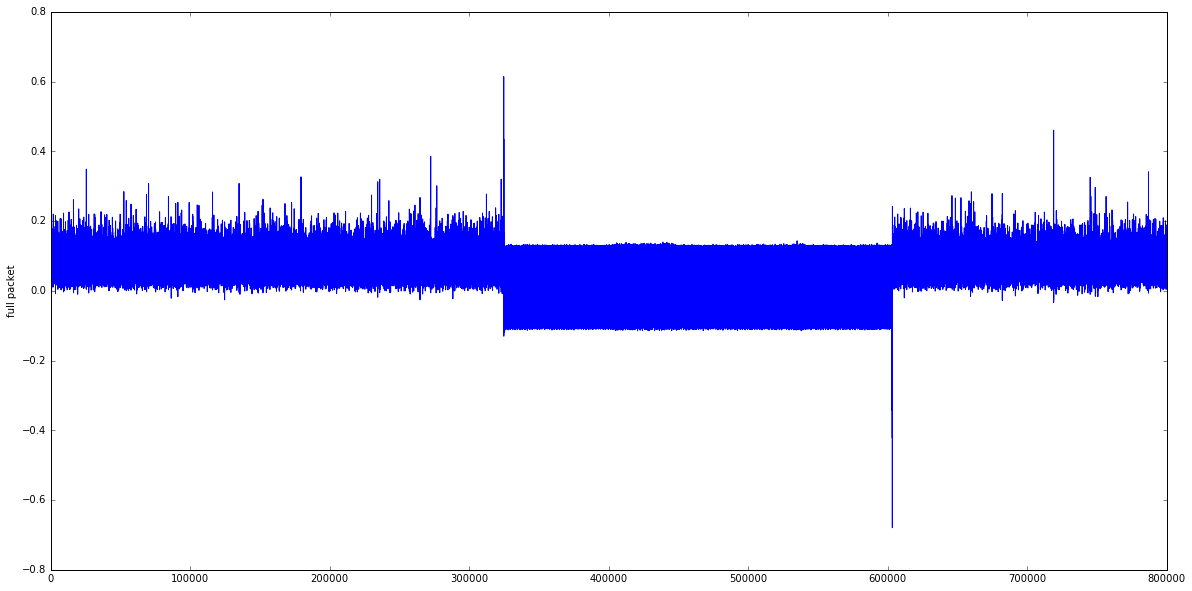

In [55]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

samples = np.fromfile('fsksignal.dat',dtype=np.float32)

# First packet is within the first 800,000 samples
samples = samples[:800000]
plt.figure(figsize=(20,10))
plt.plot(samples)
plt.ylabel('full packet')
plt.show()


### Zoom in more, and set packet bounds

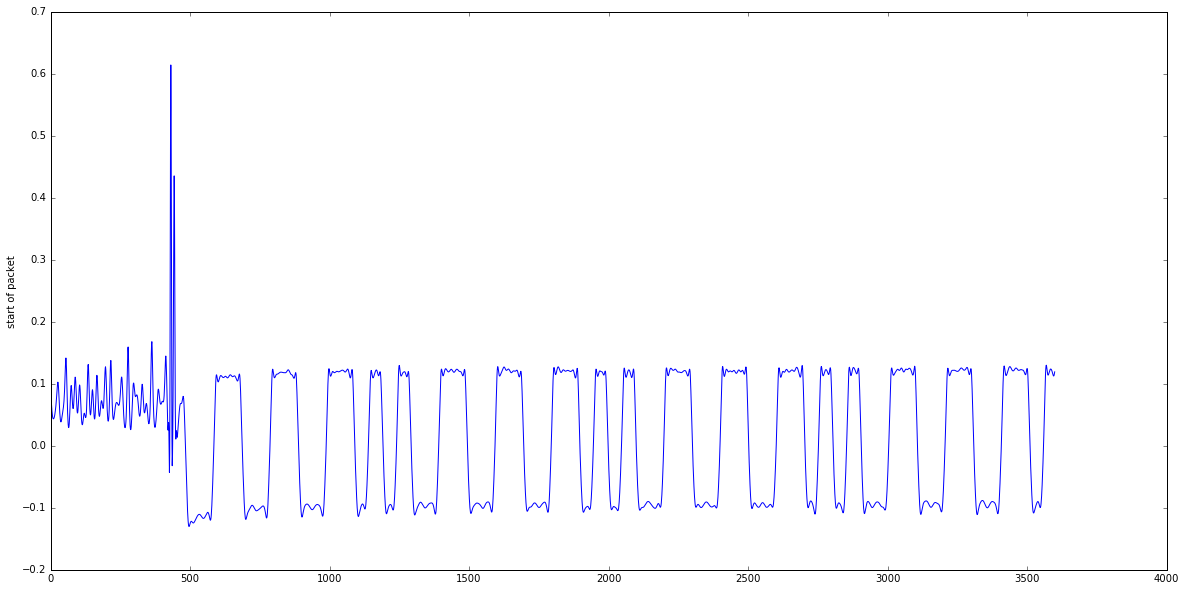

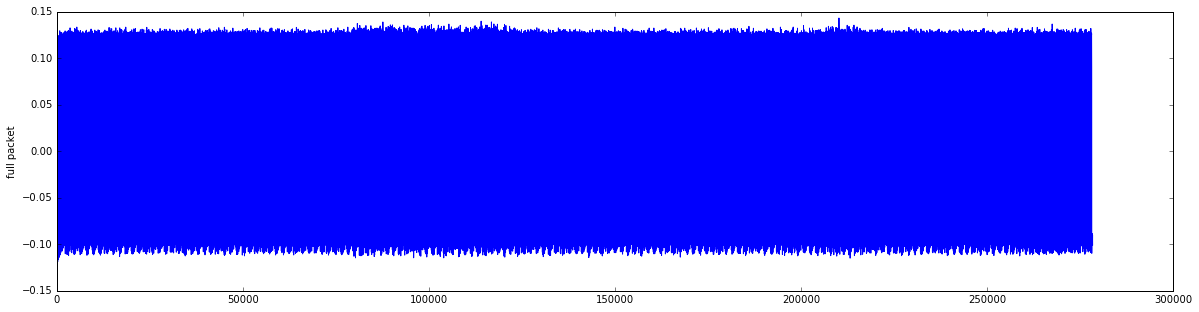

In [56]:


plt.figure(figsize=(20,10))
plt.plot(samples[324400:328000])
plt.ylabel('start of packet')
plt.show()

packet_samples = samples[324900:603305]
plt.figure(figsize=(20,5))
plt.plot(packet_samples)
plt.ylabel('full packet')
plt.show()



### Bits are 50.5 samples wide

widths = array([100, 102,  99, ...,  53,  98, 103])


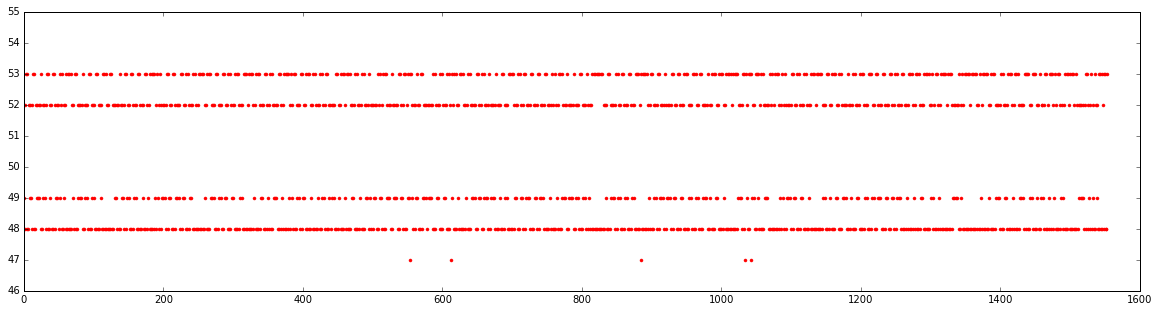

avg samples per bit = 50.4099099099


In [160]:
samples = packet_samples
signs = np.array(samples >= 0, int)
differences = np.diff(signs)
#print differences[0:1000]
crossings = np.nonzero((differences < 0) | (differences > 0))[0]
#print crossings
cumulWidths = crossings[1:] - crossings[0]
#print "cumulWidths = %s" % cumulWidths
widths = (cumulWidths[1:] - cumulWidths[:-1])
print "widths = " + repr(widths)
#plt.hist(widths,bins=30,range=[30,60])
#plt.show()
filtered_widths = widths[(widths > 46) & (widths < 55)]
plt.figure(figsize=(20,5))
plt.ylim(46,55)
plt.plot(filtered_widths,'r.')
plt.show()
samples_per_bit = filtered_widths.mean()
print "avg samples per bit = %s" % samples_per_bit



In [161]:
# Get phase of signal with the modulo of the bitrate of the first 10 crossings
phase_offset = (crossings[:10] % samples_per_bit).mean()
print "Phase offset = %s" % phase_offset

Phase offset = 34.6108108108


### Sample bits from part of packet

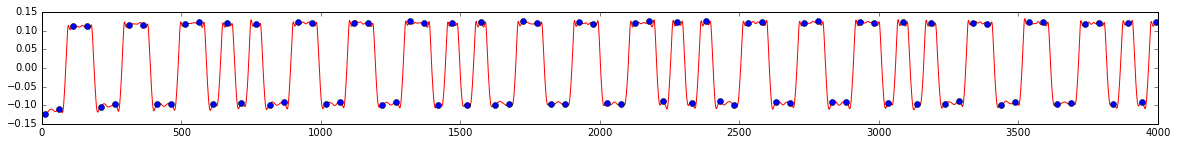

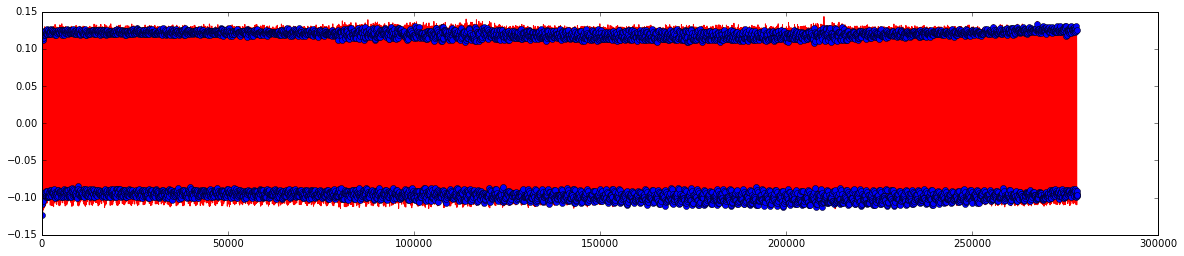

In [200]:
bit_center_offset = phase_offset - (samples_per_bit / 2.0)

def resample(samples, offset, step):
    centers = np.arange(offset, samples.size, step)
    xp = np.arange(samples.size)
    return (centers, np.interp(centers, xp, samples))

(centers, bits) = resample(samples[:4000], bit_center_offset, samples_per_bit)
plt.figure(figsize=(20,2))
plt.plot(samples[:4000], "r", centers, bits, 'bo')

(centers, bits) = resample(samples, bit_center_offset, samples_per_bit)
plt.figure(figsize=(20,4))
plt.plot(samples, "r", centers, bits, 'bo')


### Get bits for entire packet

In [206]:
(centers, bits) = resample(samples, bit_center_offset, samples_per_bit)
bits = (bits > 0).astype(int)
print "".join(map(str, bits[:80]))

00110011001101010011001100110101001100110011010100110011001101010011001100110101


### Manchester decoding

In [211]:
def manchester_decode(bits, mode='ieee'):
    decoded = []
    if mode == 'ieee':
        hi_low = 0
        low_hi = 1
    else:
        hi_low = 1
        low_hi = 0
        
    prev = None
    for bit in bits:
        if prev == None:
            prev = bit
            continue
        
        if prev == 0 and bit == 1:
            d = low_hi
            prev = None
        elif prev == 1 and bit == 0:
            d = hi_low
            prev = None
        else:
            d = -1 # Error
            prev = bit
            
        decoded.append(d)
    return np.array(decoded)


In [216]:
decoded_bits = manchester_decode(bits)
decoded_bits = np.trim_zeros(decoded_bits + 1) - 1 # Trim leading and trailing errors
print "decoded size = %s" % decoded_bits.size
print "First manchester decoded bits: " + "".join(map(str, decoded_bits[:40]))

decoded size = 2759
First manchester decoded bits: 1010100010101000101010001010100010101000


In [217]:
bytes = np.packbits(decoded_bits)
"".join([format(n, '02x') for n in bytes])

'a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a8a98600000000b800000001f7f3f1f7c1fd6fa9f900e4'